# Seasonality analysis

In [45]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD



# set maximum number of years to analyze
max_num_of_years = 5



# show seasonality in % instead of currency
seasonalityInPercent = False




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: EBAY

* **Max years to analyse**: 2022 until earliest 2018

In [46]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')

D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _EBAY_

* From 24.09.98 to 30.06.23

## Statistics:

             Close
count  6232.000000
mean     22.115561
std      15.992768
min       0.508558
25%      10.003156
50%      16.702440
75%      31.852500
max      80.589996


## Data:

                Close
Date                 
1998-09-24   0.830791
1998-09-25   0.786949
1998-09-28   0.846135
1998-09-29   0.857095
1998-09-30   0.790237
...               ...
2023-06-26  43.459999
2023-06-27  44.470001
2023-06-28  44.840000
2023-06-29  44.599998
2023-06-30  44.599998

[6232 rows x 1 columns]


In [47]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

annualDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[str(year)] = curYearValues

resultMean = annualDf.mean(axis=1)
resultMin = annualDf.min(axis=1)
resultMax = annualDf.max(axis=1)
annualDf['mean'] = resultMean
annualDf['min'] = resultMin
annualDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
annualDf['date'] = range
annualDf = annualDf.set_index('date')

# annualDf.index = resultDf.index.strftime('%d. %b')

D('## Initial data overview')
annualDf

## Initial data overview

,2022,2021,2020,2019,2018,mean,min,max
date,,,,,,,,
2022-01-01,66.500000,50.250000,36.110001,28.070000,37.740002,43.734000,28.070000,66.500000
2022-01-02,66.500000,50.250000,36.299999,28.850000,38.060001,43.992000,28.850000,66.500000
2022-01-03,66.800003,50.250000,35.959999,28.320000,39.220001,44.110001,28.320000,66.800003
2022-01-04,65.139999,51.500000,35.959999,28.969999,38.570000,44.027999,28.969999,65.139999
2022-01-05,64.489998,52.029999,35.959999,28.969999,39.689999,44.227999,28.969999,64.489998
...,...,...,...,...,...,...,...,...
2022-12-27,40.080002,65.660004,50.119999,36.070000,28.030001,43.992001,28.030001,65.660004
2022-12-28,39.919998,66.080002,50.240002,36.070000,28.240000,44.110000,28.240000,66.080002
2022-12-29,41.820000,66.459999,50.860001,36.070000,28.240000,44.690000,28.240000,66.459999


In [48]:
periods = [4, 12, 52, 365]
periodNames = ['seasonal_' + str(i) for i in periods]

decompose = MSTL(df['Close'], periods=periods)
decompose = decompose.fit()

numOfYears = 0
retDf = pd.DataFrame()
for year in sorted(list(set(decompose.seasonal[periodNames[3]].index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[periodNames[3] + '_' + str(year)] = curYearValues

D('## Seasonal decomposition')
annualDf

## Seasonal decomposition

,2022,2021,2020,2019,2018,mean,min,max,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018
date,,,,,,,,,,,,,
2022-01-01,66.500000,50.250000,36.110001,28.070000,37.740002,43.734000,28.070000,66.500000,-2.548723,-2.318625,-2.261746,-2.014566,-1.773951
2022-01-02,66.500000,50.250000,36.299999,28.850000,38.060001,43.992000,28.850000,66.500000,-2.580286,-2.343387,-2.091502,-1.868907,-1.651453
2022-01-03,66.800003,50.250000,35.959999,28.320000,39.220001,44.110001,28.320000,66.800003,-2.303747,-2.102680,-2.109529,-1.880370,-1.656538
2022-01-04,65.139999,51.500000,35.959999,28.969999,38.570000,44.027999,28.969999,65.139999,-1.991260,-1.827472,-1.903136,-1.707028,-1.515185
2022-01-05,64.489998,52.029999,35.959999,28.969999,39.689999,44.227999,28.969999,64.489998,-1.780368,-1.630431,-1.665005,-1.505375,-1.348995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,40.080002,65.660004,50.119999,36.070000,28.030001,43.992001,28.030001,65.660004,-3.049704,-2.793072,-2.538167,-2.443487,-2.179276
2022-12-28,39.919998,66.080002,50.240002,36.070000,28.240000,44.110000,28.240000,66.080002,-2.946040,-2.706633,-2.467985,-2.287113,-2.040816
2022-12-29,41.820000,66.459999,50.860001,36.070000,28.240000,44.690000,28.240000,66.459999,-2.650490,-2.446382,-2.240958,-2.232501,-2.001347


In [49]:
monthlyDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues


montlyMean = monthlyDf.mean(axis=1)
monthlyStd = monthlyDf.std(axis=1)
monthlyMax = monthlyDf.max(axis=1)
monthlyDf['mean'] = montlyMean
monthlyDf['std'] = monthlyStd

monthlyDf['meanPositive'] = monthlyDf['mean'] > 0

range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
monthlyDf['date'] = range
monthlyDf = monthlyDf.set_index('date')
monthlyDf.index = monthlyDf.index.strftime('%b')

D('## Monthly mean')
monthlyDf

## Monthly mean

,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018,mean,std,meanPositive
date,,,,,,,,
Jan,-0.786269,-0.744070,-0.785695,-0.735257,-0.687547,-0.747768,0.040980,False
Feb,0.815661,0.741906,0.655159,0.617230,0.533735,0.672738,0.109457,True
Mar,-1.661352,-1.459154,-1.269578,-1.084665,-0.917900,-1.278530,0.294489,False
Apr,-0.856870,-0.765256,-0.676357,-0.591941,-0.510041,-0.680093,0.137118,False
May,-1.633378,-1.472180,-1.317993,-1.164183,-1.018305,-1.321208,0.243238,False
Jun,0.024850,-0.010628,-0.047100,-0.119907,-0.143059,-0.059169,0.071218,False
Jul,2.633810,2.379597,2.129024,1.826586,1.597796,2.113363,0.415344,True
Aug,3.411883,3.099223,2.794599,2.486884,2.200420,2.798602,0.479972,True
Sep,1.370517,1.283687,1.197454,1.204359,1.110331,1.233270,0.098249,True


<Axes: title={'center': 'Annual monthly mean performance'}, xlabel='date', ylabel='USD'>

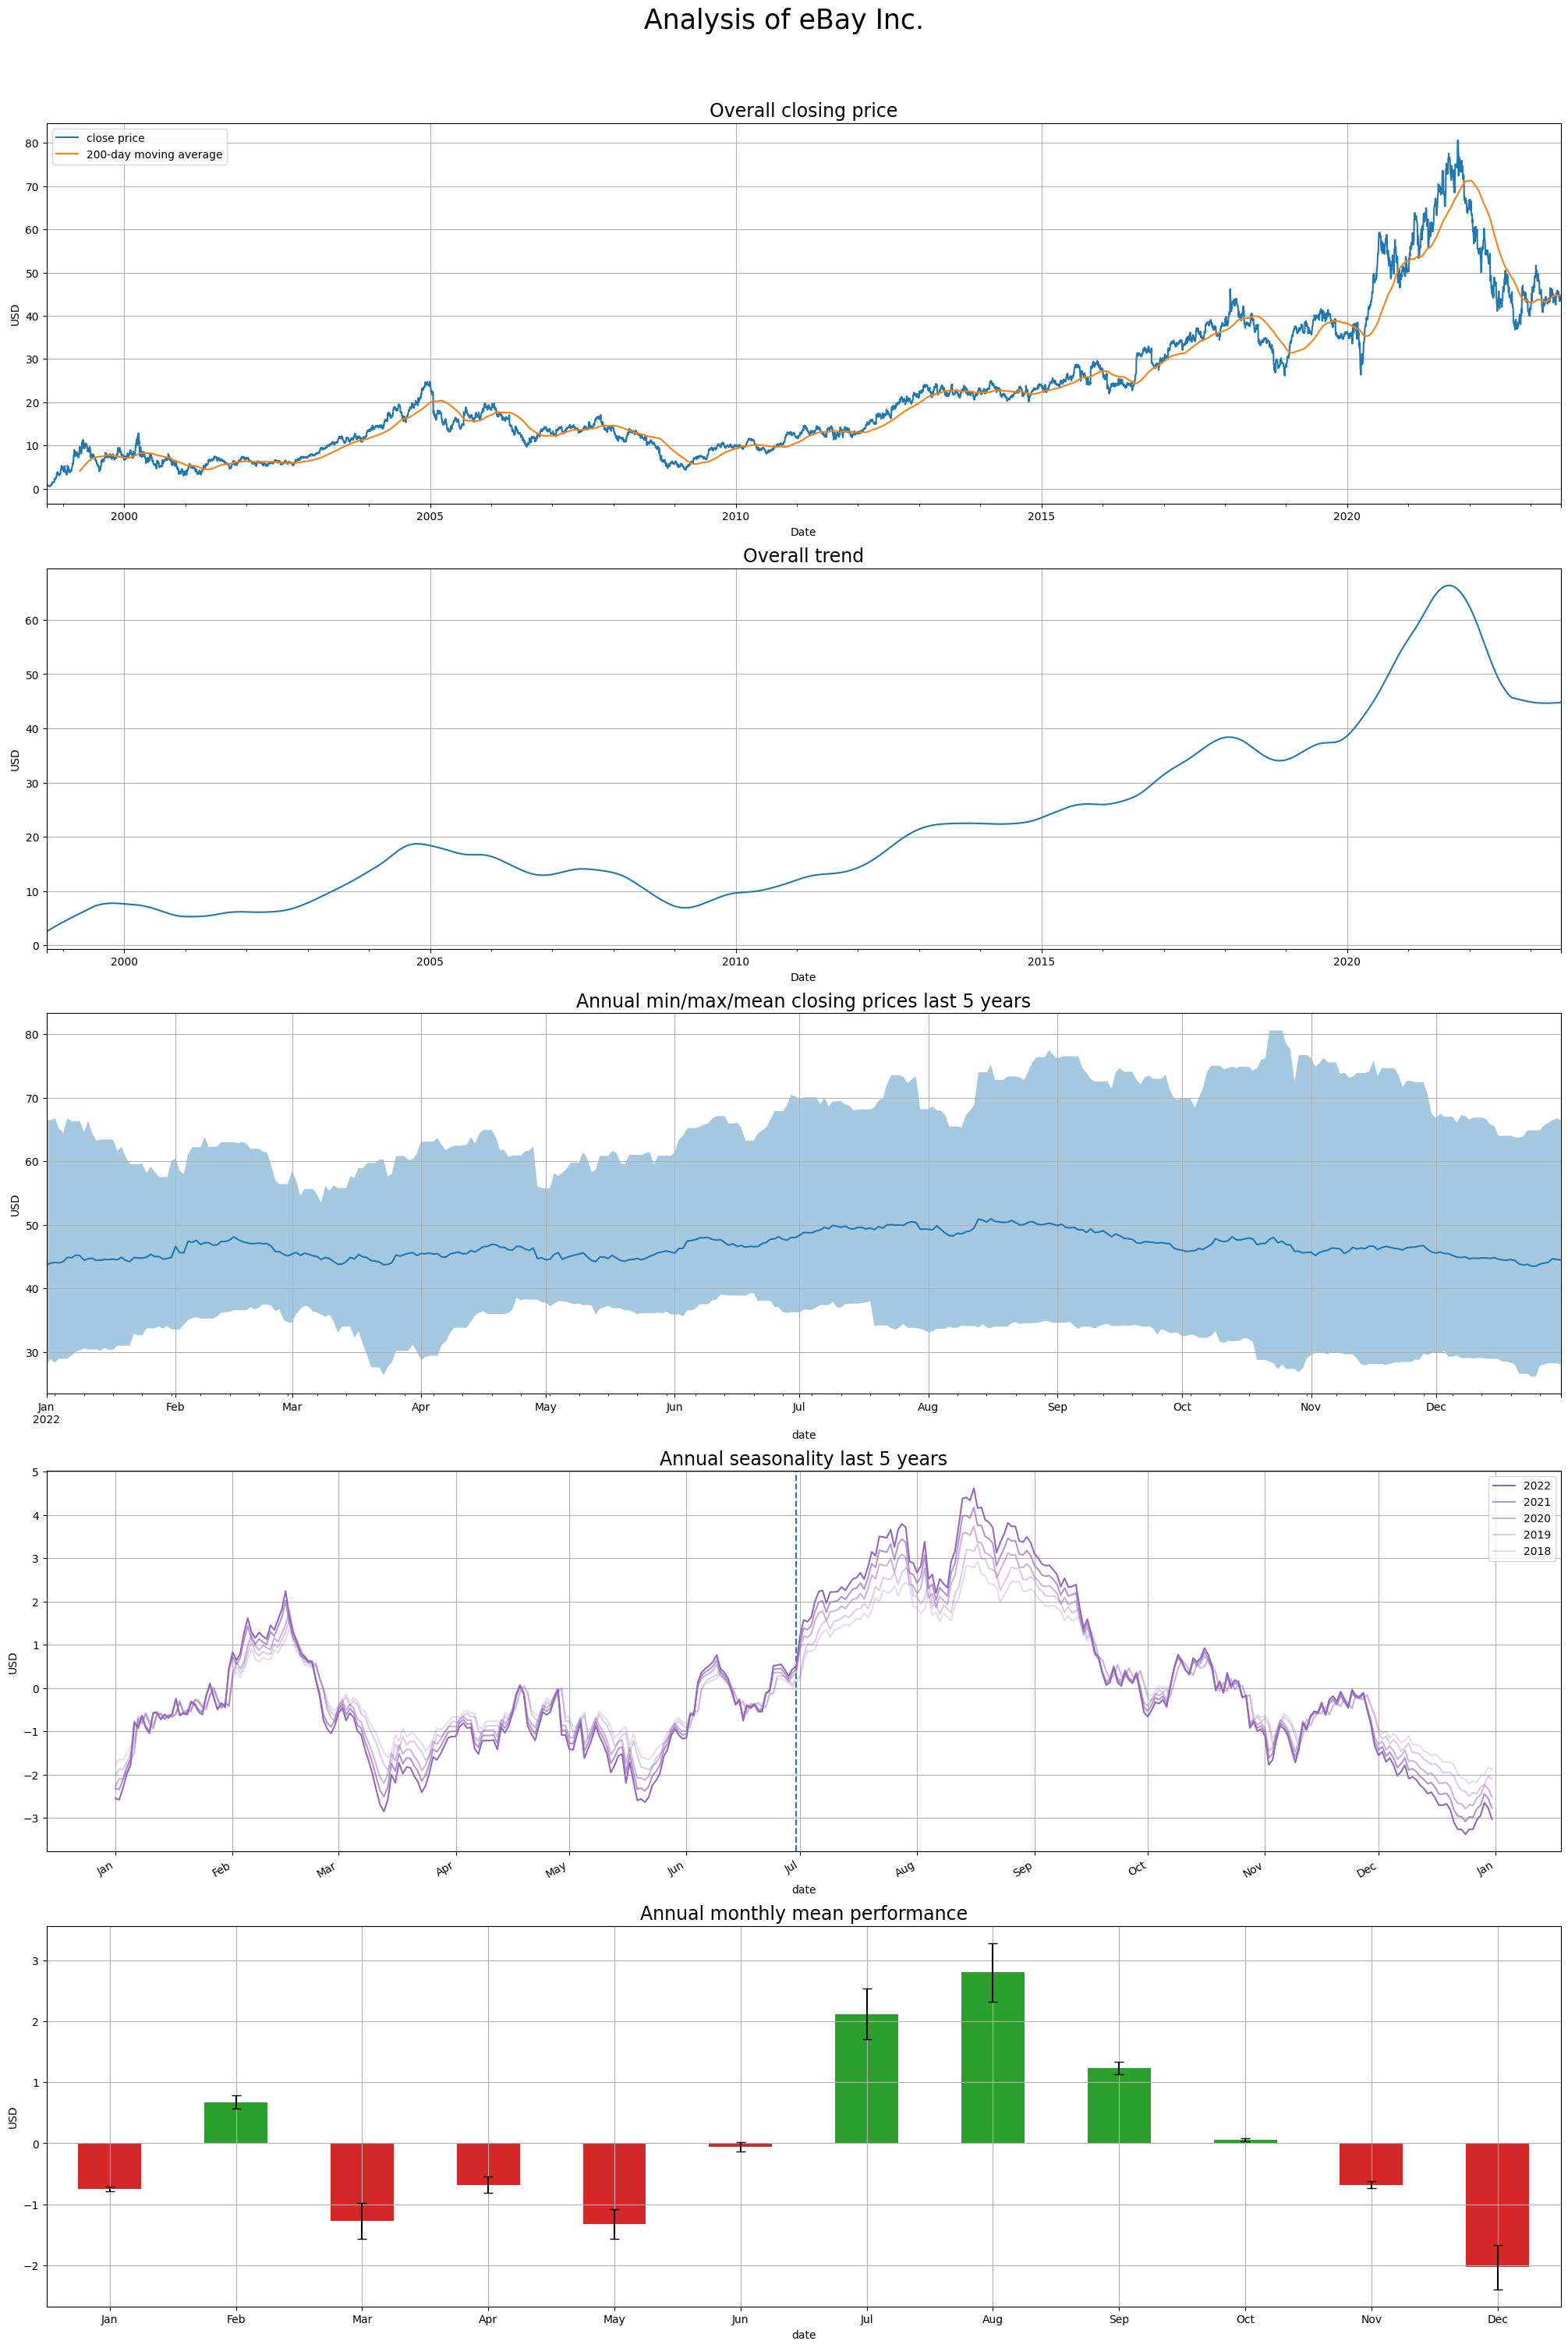

In [50]:
plt.figure(figsize=(20, 30), layout='constrained')
plt.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=25)

plt.subplot(511)
plt.title('Overall closing price', fontsize=17)
plt.ylabel(ticker.info['currency'])
df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)

plt.subplot(512)
plt.title('Overall trend', fontsize=17)
plt.ylabel(ticker.info['currency'])
decompose.trend.plot(grid=True)

plt.subplot(513)
plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
plt.ylabel(ticker.info['currency'])
annualDf['mean'].plot(grid=True)

plt.subplot(514)
plt.title(f'Annual seasonality last {max_num_of_years} years', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
if seasonalityInPercent:
    plt.ylabel('%')
else:
    plt.ylabel(ticker.info['currency'])
alpha_value = 1
for col in annualDf.columns:
    if col.startswith(periodNames[3]):
        if seasonalityInPercent:
            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
        else:
            usedAnnualDf = annualDf[col]
        usedAnnualDf.plot(legend=True, label=col[-4:], color='tab:purple', alpha=alpha_value, grid=True)
        alpha_value = alpha_value * 0.7

plt.subplot(515)
plt.title('Annual monthly mean performance', fontsize=17)
plt.ylabel(ticker.info['currency'])
monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)